In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro, levene, ttest_ind

# 1. Introduction

## 1.1 Business Problem

Recently, Meta introduced a new bidding strategy named "average bidding" as an alternative to the existing "maximum bidding" approach. A client has opted to test this new feature and wishes to conduct an A/B test to ascertain whether average bidding produces a higher conversion rate compared to maximum bidding. The A/B test has been in progress for a month and the client now awaits analysis of the results. The primary success metric for the client is the number of purchases. Consequently, the emphasis for statistical testing should be on the purchase metric.

## 1.2 Dataset Story

This dataset comprises information related to a company's website, encompassing details such as the quantity of ads viewed and clicked by users, alongside revenue figures derived from these interactions. Two distinct datasets are available, designated for the control and test groups, respectively. These datasets are organized on separate pages within the spreadsheet file. Maximum bidding has been implemented for the control group, while the test group is subjected to average bidding.

## 1.3 Features

- `Impression` - Number of ad displays
- `Click` - Number of clicks on displayed ads
- `Purchase` - Number of products purchased following ad clicks
- `Earning` - Revenue generated from purchased products

# 2. Data Handling

## 2.1 Loading Data

In [2]:
# Load the dataset
control_data = pd.read_excel('ab_testing.xlsx', 'Control Group')
test_data = pd.read_excel('ab_testing.xlsx', 'Test Group')

In [3]:
# Display the first few rows
control_data.head()

,Impression,Click,Purchase,Earning
0,82529.459271,6090.077317,665.211255,2311.277143
1,98050.451926,3382.861786,315.084895,1742.806855
2,82696.023549,4167.965750,458.083738,1797.827447
3,109914.400398,4910.882240,487.090773,1696.229178
4,108457.762630,5987.655811,441.034050,1543.720179


In [4]:
# Display the first few rows
test_data.head()

,Impression,Click,Purchase,Earning
0,120103.503796,3216.547958,702.160346,1939.611243
1,134775.943363,3635.082422,834.054286,2929.405820
2,107806.620788,3057.143560,422.934258,2526.244877
3,116445.275526,4650.473911,429.033535,2281.428574
4,145082.516838,5201.387724,749.860442,2781.697521


## 2.2 Inspecting Data

In [5]:
# Display basic statistics about the dataset
control_data.describe()

,Impression,Click,Purchase,Earning
count,40.000000,40.000000,40.000000,40.000000
mean,101711.449068,5100.657373,550.894059,1908.568300
std,20302.157862,1329.985498,134.108201,302.917783
min,45475.942965,2189.753157,267.028943,1253.989525
25%,85726.690349,4124.304129,470.095533,1685.847205
50%,99790.701078,5001.220602,531.206307,1975.160522
75%,115212.816543,5923.803596,637.957088,2119.802784
max,147539.336329,7959.125069,801.795020,2497.295218


In [6]:
# Display basic statistics about the dataset
test_data.describe()

,Impression,Click,Purchase,Earning
count,40.000000,40.000000,40.000000,40.000000
mean,120512.411758,3967.549761,582.106097,2514.890733
std,18807.448712,923.095073,161.152513,282.730852
min,79033.834921,1836.629861,311.629515,1939.611243
25%,112691.970770,3376.819024,444.626828,2280.537426
50%,119291.300775,3931.359804,551.355732,2544.666107
75%,132050.578933,4660.497911,699.862360,2761.545405
max,158605.920483,6019.695079,889.910460,3171.489708


In [7]:
# Display information about the dataset
control_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Impression  40 non-null     float64
 1   Click       40 non-null     float64
 2   Purchase    40 non-null     float64
 3   Earning     40 non-null     float64
dtypes: float64(4)
memory usage: 1.4 KB


In [8]:
# Display information about the dataset
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Impression  40 non-null     float64
 1   Click       40 non-null     float64
 2   Purchase    40 non-null     float64
 3   Earning     40 non-null     float64
dtypes: float64(4)
memory usage: 1.4 KB


## 2.3 Data Cleaning and Preprocessing

In [9]:
# Add labels to control and test datasets
control_data['Group'] = 'C'
test_data['Group'] = 'T'

# Combine control and test datasets
data = pd.concat([control_data, test_data], axis=0, ignore_index=True)

# Delete original datasets
del control_data, test_data

In [10]:
def categorize_columns(df, cat_th=10, high_card_th=20):
    """
    Categorizes columns in a DataFrame based on specified thresholds.

    Parameters:
    - df: DataFrame
    - cat_thresh: Threshold for considering a column as categorical (default is 10)
    - high_card_thresh: Threshold for considering a categorical column as having high cardinality (default is 20)

    Returns:
    - cat_cols: List of categorical columns
    - num_cols: List of numerical columns
    - high_card_cat_cols: List of categorical columns with high cardinality
    """

    # Identify categorical columns with high cardinality
    high_card_cols = [col for col in df.columns if
                      df[col].dtype in ["category", "object"] and df[col].nunique() > high_card_th]

    # Identify numerical columns that are treated as categorical
    num_but_cat_cols = [col for col in df.columns if
                        df[col].dtype in ["float64", "int64"] and df[col].nunique() < cat_th]

    # Identify categorical columns
    cat_cols = [col for col in df.columns if
                (df[col].dtype in ["category", "object", "bool"] and col not in high_card_cols) or
                (col in num_but_cat_cols)]

    # Identify numerical columns
    num_cols = [col for col in df.columns if df[col].dtype in ["float64", "int64"] and col not in cat_cols]

    # Print dataset overview
    print(f"Dataset Overview:")
    print(f" - Total Columns: {df.shape[1]}")
    print(f" - Numerical Columns: {len(num_cols)}")
    print(f" - Numerical Columns Treated as Categorical: {len(num_but_cat_cols)}")
    print(f" - Categorical Columns: {len(cat_cols)}")
    print(f" - Columns with High Cardinality: {len(high_card_cols)}")

    return cat_cols, num_cols, high_card_cols


# Categorize columns of the dataset
cat_cols, num_cols, high_card_cols = categorize_columns(data)

Dataset Overview:
 - Total Columns: 5
 - Numerical Columns: 4
 - Numerical Columns Treated as Categorical: 0
 - Categorical Columns: 1
 - Columns with High Cardinality: 0


# 3. Data Visualization

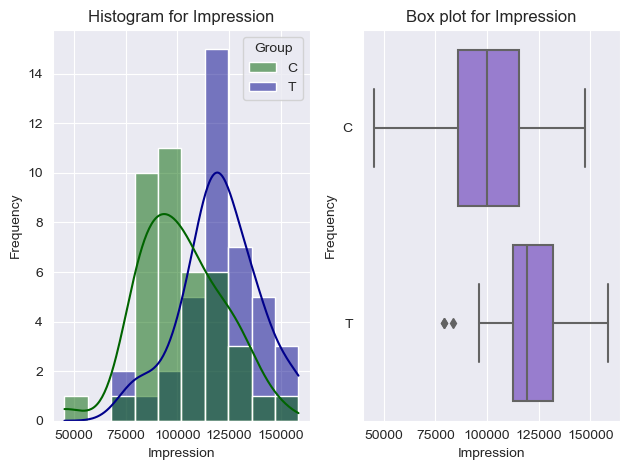

82529.459271     1
98050.451926     1
115934.854388    1
83356.587558     1
134387.168921    1
                ..
94472.196589     1
123961.868719    1
80254.331644     1
83676.602428     1
102257.454089    1
Name: Impression, Length: 80, dtype: int64


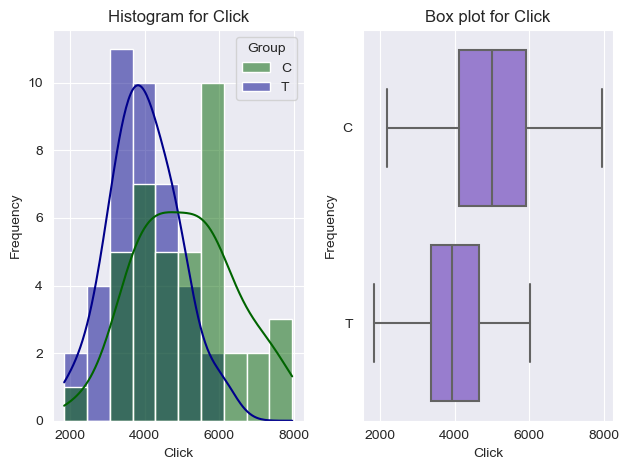

6090.077317    1
3382.861786    1
5059.858452    1
6019.695079    1
4986.100732    1
              ..
5937.479474    1
4898.788414    1
3075.311196    1
7153.974195    1
4800.068321    1
Name: Click, Length: 80, dtype: int64


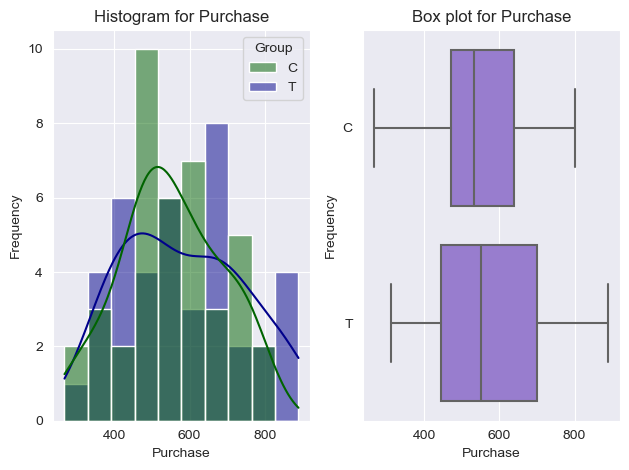

665.211255    1
315.084895    1
653.491515    1
570.432128    1
417.990340    1
             ..
686.412286    1
585.639167    1
530.679884    1
487.828774    1
521.310729    1
Name: Purchase, Length: 80, dtype: int64


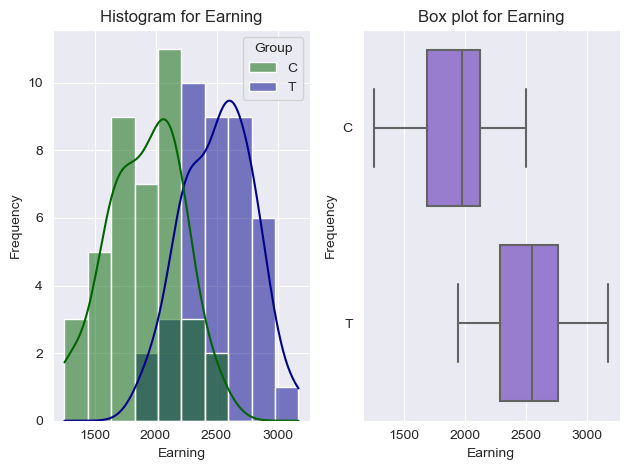

2311.277143    1
1742.806855    1
2682.820438    1
2537.676208    1
2087.988270    1
              ..
1616.589007    1
2042.182931    1
2101.319485    1
1989.641918    1
2967.518390    1
Name: Earning, Length: 80, dtype: int64


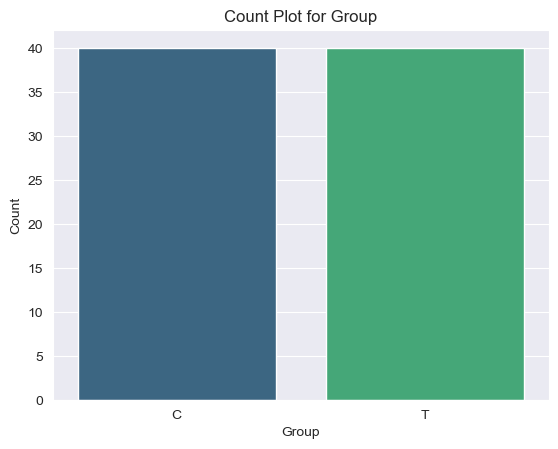

C    40
T    40
Name: Group, dtype: int64


In [11]:
def summary_plots(df, num_cols=None, cat_cols=None, log_scale=False, groupby=None):
    """
    Generate summary plots for numerical and categorical columns in a DataFrame.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - num_cols (list, optional): List of numerical column names. Defaults to None.
    - cat_cols (list, optional): List of categorical column names. Defaults to None.
    """

    # Plot histograms and box plots for numerical columns
    if num_cols is not None:
        for col in num_cols:
            # Create subplots for histograms and boxplots
            fig, axes = plt.subplots(1, 2)

            # Histogram
            sns.histplot(data=df, x=col, bins=10, kde=True, palette=sns.color_palette(['darkgreen', 'darkblue']),
                         hue=groupby,
                         ax=axes[0]) if groupby is not None else sns.histplot(data=df, x=col, bins=10, kde=True,
                                                                              color='darkgreen', ax=axes[0])
            axes[0].set_title(f'Histogram for {col}')
            axes[0].set_xlabel(col)
            axes[0].set_ylabel('Frequency')
            axes[0].set_yscale('log') if log_scale == True else _

            # Box plot
            sns.boxplot(data=df, x=col, y=groupby, color='mediumpurple',
                        ax=axes[1]) if groupby is not None else sns.boxplot(data=df, x=col, color='mediumpurple',
                                                                            ax=axes[1])
            axes[1].set_title(f'Box plot for {col}')
            axes[1].set_xlabel(col)
            axes[1].set_ylabel('Frequency')
            axes[1].set_yscale('log') if log_scale == True else _

            # Adjust layout
            plt.tight_layout()

            # Show the plots
            plt.show()

            # Display the counts of unique values in the column
            print(df[col].value_counts())

    # Plot count plots for categorical columns
    if cat_cols is not None:
        for col in cat_cols:
            sns.countplot(x=col, data=df, palette='viridis')
            plt.title(f'Count Plot for {col}')
            plt.xlabel(col)
            plt.ylabel('Count')
            plt.yscale('log') if log_scale == True else _

            # Show the plots
            plt.show()

            # Display the counts of unique values in the column
            print(df[col].value_counts())


# Generate summary plots for numerical and categorical columns
summary_plots(data, num_cols, cat_cols, log_scale=False, groupby='Group')

# 4. Data Analysis

When conducting an A/B test based on gathered data, it is essential to perform a hypothesis test. The most suitable test for this scenario can be determined using the chart below:

<br>

1. **Formulation of the Hypothesis**
    - Clearly define the null hypothesis $H_0$ and alternative hypothesis $H_1$, based on the expected difference between the two groups.

2. **Assumption Checking**
    - Verify the assumptions required for the t-test, including:
        - **Normality:** Conduct tests such as the $\text{Shapiro-Wilk test}$ or $\text{Anderson-Darling test}$ test to assess normality.
        - **Homoskedasticity:** Utilize tests like $\text{Levene's test}$ or $\text{Bartlett's test}$ to evaluate homogeneity of variances.

3. **Application of the Hypothesis Test**
    - Based on the outcomes of the assumption checks:
        - If normality is satisfied:
            - If homoskedasticity is satisfied:
                - Apply the parametric test ($\text{independent two-sample t-test}$).
            - If homoskedasticity is not satisfied:
                - Apply the parametric test ($\text{independent two-sample t-test}$), set `equal_var=False`.
        - If normality is not satisfied:
            - Apply the non-parametric test ($\text{Mann-Whitney U rank test}$).

4. **Interpretation of Results Based on $\text{p-values}$**
   - Evaluate the $\text{p-values}$ derived from the hypothesis test.
   - If $\text{p-values}$ fall below the predetermined significance level (commonly $\alpha = 0.05$), reject the null hypothesis.
   - Interpret the findings within the context of the research question and the formulated hypotheses.

This systematic approach ensures a thorough and structured application of the $\text{independent two-sample t-test}$, considering both parametric and non-parametric alternatives based on the fulfillment of assumptions.

## 4.1 Formulation of the Hypothesis

$$H_0: \mu_1 = \mu_2$$
$$H_1: \mu_1 \ne \mu_2$$

$H_0:$ There is no statistically significant difference in the mean purchase amounts between the control and test groups.
$H_1:$ There is a statistically significant difference in the mean purchase amounts between the control and test groups.

- If $p \lt \alpha$, reject $H_0$
- If $p \ge \alpha$, fail to reject $H_1$

### 4.2.1 Assumption Checking: Normality

$$H_0: \text{The assumption of normality is satisfied}$$
$$H_1: \text{The assumption of normality is not satisfied}$$

- If $p \lt \alpha$, reject $H_0$
- If $p \ge \alpha$, fail to reject $H_1$

In [12]:
# Define significance level
alpha = 0.05

# Normality test on the control group
_, p_value = shapiro(data[data['Group'] == 'C']['Purchase'])
print(f"- Normality is {'not satisfied' if p_value < alpha else 'satisfied'} for the control group")

# Normality test on the test group
_, p_value = shapiro(data[data['Group'] == 'T']['Purchase'])
print(f"- Normality is {'not satisfied' if p_value < alpha else 'satisfied'} for the test group")

- Normality is satisfied for the control group
- Normality is satisfied for the test group


### 4.2.2 Assumption Checking: Homoskedasticity

$$H_0: \text{The assumption of homogeneity of variance is satisfied}$$
$$H_1: \text{The assumption of homogeneity of variance is not satisfied}$$

- If $p \lt \alpha$, reject $H_0$
- If $p \ge \alpha$, fail to reject $H_1$

In [13]:
# Define significance level
alpha = 0.05

# Homoskedasticity test for the groups
_, p_value = levene(data[data['Group'] == 'C']['Purchase'], data[data['Group'] == 'T']['Purchase'])
print(f"- Homoskedasticity is {'not satisfied' if p_value < alpha else 'satisfied'}")

- Homoskedasticity is satisfied


## 4.3 Application of the Hypothesis Test

- Both tests failed to reject the null hypothesis ($H_0$), indicating that both *normality* and *homoskedasticity* assumptions are satisfied.
- Given that *normality* is satisfied, the $\text{independent two-sample t-test}$ will be utilized.
- As *homoskedasticity* is satisfied, there is no need to set the `equal_var` parameter to `False`.

In [14]:
# Define the significance level
alpha = 0.05

# Perform independent two-sample t-test
_, p_value = ttest_ind(data[data['Group'] == 'C']['Purchase'], data[data['Group'] == 'T']['Purchase'])
print(
    f"There is {'no' if p_value < alpha else 'a'} statistically significant difference in the mean purchase amounts between the control and test groups.")

There is a statistically significant difference in the mean purchase amounts between the control and test groups.
